# Imports

In [1]:
import argparse
import joblib
import numpy as np
import pandas as pd
from typing import Text
import yaml
from colorama import Fore
from tqdm import tqdm
from pathlib import Path
import os
import sys 



In [2]:
#machine = "local"
machine = "paperspace"

if machine == "local":
    src_dir= Path.cwd().parent    
elif machine == "paperspace":
    src_dir = Path("/notebooks/inferess-relation-extraction/")

sys.path.append(str(src_dir))


In [3]:
from src.utils import get_logger, dict2dot
from src.language_model.spacy_loader import SpacyLoader


# load_data.py

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

config_path = 'params.yaml'

"""
Load and validate data
""" 

"""Load raw data.
Args:
    config_path {Text}: path to config
"""

with open(src_dir / config_path) as conf_file:
    config = dict2dot(yaml.safe_load(conf_file))

logger = get_logger('DATA_LOAD', log_level=config.base['log_level'])
logger.info('Load dataset')
## Read relations file
data = pd.read_json(src_dir / config.load_data.dataset)
data = data.dropna(subset=[config.load_data['text_col'],
                     config.load_data.entity_1,
                     config.load_data.entity_2])

## Check missed columns 
missed_columns = set([
  config.load_data['text_col'],
  config.load_data.entity_1 ,
  config.load_data.entity_2,
  config.sc_train['target']]) - set(data.columns)


if len(missed_columns) > 0: 
    raise ValueError(f"Required columns missed <{','.join(x for x in missed_columns)}>")

if config.load_data['target'] is not None:
    data.rename(columns={config.load_data['target']: 'relations'},inplace=True)

data['relations'] = data['relations'].apply(lambda x : "other" if x not in\
                                       config.base['main_relations']\
                                       else x)


data.rename(columns={config.load_data.text_col:'sents',
                     config.load_data.entity_1:'entity_1',
                     config.load_data.entity_2: 'entity_2',}, inplace=True)
## annotate enities if missed
if not 'spans' in data.columns or not 'org_groups' in data.columns: 
    spacy_loader = SpacyLoader(lm='en_core_web_trf',
        require_gpu=True,
        load_matcher=True)
    sents, spans, groups, aliases = spacy_loader.predictor(data['sents'].tolist())
    data['sents'] = sents
    data['spans'] = spans
    data['org_groups'] = groups
    data['aliases'] = aliases
# Generate unique IDs for unique strings in the column `sentence`
if config.base.index_col not in data.columns:
    unique_ids, unique_strings = pd.factorize(data[config.base.index_col])
    logger.info("add idx")
    data.loc[:, config.base.index_col] = unique_ids
else:
    unique_ids, unique_strings = pd.factorize(data[config.base.index_col])
    data.loc[:, config.base.index_col] = unique_ids
data['idx_relation'] = data.groupby(config.base.index_col).cumcount()

2023-10-19 07:51:16,729 — DATA_LOAD — INFO — Load dataset


/tmp/ipykernel_3919/2716184175.py:64: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, config.base.index_col] = unique_ids


In [6]:
data.head()

,sents,entity_2,relations,entity_1,Label,concept_class,idx,org_groups,spans,idx_relation
0,"On March 31, 2014, Tessera Inc filed a motion ...",Tessera Inc,other,Amkor,0,legal_and_regulatory,0,"{'Tessera Inc': 0, 'Amkor': 1}","[{'text': 'March 31, 2014', 'label': 'DATE', '...",0
1,BE Aerospace TSA received an opinion from tax ...,BE Aerospace TSA,other,KLX,0,unknown,1,"{'BE Aerospace TSA': 0, 'KLX': 2}","[{'text': 'BE Aerospace TSA', 'label': 'ORG', ...",0
2,Resort Savers Inc reports that Beijng Fanshan ...,Beijng Fanshan Yandong Chemical Factory,other,Resort Savers Inc,0,unknown,2,"{'Beijng Fanshan Yandong Chemical Factory': 0,...","[{'text': 'Resort Savers Inc', 'label': 'ORG',...",0
3,Resort Savers Inc reports that Beijng Fanshan ...,Beijng Fanshan Yandong Chemical Factory,other,Fanshan Disctrict,0,unknown,2,"{'Beijng Fanshan Yandong Chemical Factory': 0,...","[{'text': 'Resort Savers Inc', 'label': 'ORG',...",1
4,Resort Savers Inc reports that Beijng Fanshan ...,Resort Savers Inc,other,Fanshan Disctrict,0,unknown,2,"{'Beijng Fanshan Yandong Chemical Factory': 0,...","[{'text': 'Resort Savers Inc', 'label': 'ORG',...",2


In [7]:
data.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            20863, 20864, 20865, 20866, 20867, 20868, 20869, 20870, 20871,
            20872],
           dtype='int64', length=20873)

In [8]:

np.save(src_dir / "data/train/row_ids", unique_strings)

logger.info(Fore.GREEN + "Data loaded successfully!!!" + Fore.RESET)
logger.info(Fore.BLUE+ f"Save training data into `{config.load_data.output_dir}`" + Fore.RESET)
data.to_json(src_dir / config.load_data.output_dir, index='index')




2023-10-07 07:29:44,093 — DATA_LOAD — INFO — Data loaded successfully!!!
2023-10-07 07:29:44,095 — DATA_LOAD — INFO — Save training data into `data/raw/relations_training_data.json`


In [9]:
data = pd.read_json(src_dir / 'data/raw/relations_training_data.json')

In [10]:
data[data['entity_1'].isnull()].shape[0] == 0

True

# **_data split_**

In [12]:
import argparse
import joblib
from glob import glob
import pandas as pd
from matplotlib import pyplot  as plt
from typing import Text
import yaml
from colorama import Fore
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import random
import os
import sys

from src.utils import get_logger, dict2dot, split_data
from src.utils.preprocess import create_re_data
from src.relation_extraction.preprocessing_funcs import inverse_dict

sort dataset by indices:   0%|          | 0/5888 [00:00<?, ?it/s]

sort dataset by indices:   0%|          | 0/1473 [00:00<?, ?it/s]

2023-10-07 07:32:28,386 — data_split — INFO — Train and valid distributions
|                           |   train_concept_class |   valid_concept_class |   train_Label |   valid_Label |
|:--------------------------|----------------------:|----------------------:|--------------:|--------------:|
| revenue                   |             0.320572  |             0.314587  |     nan       |    nan        |
| agreement_and_partnership |             0.121326  |             0.118901  |     nan       |    nan        |
| investment_related        |             0.119618  |             0.144838  |     nan       |    nan        |
| supply_chain              |             0.0975911 |             0.0793529 |     nan       |    nan        |
| unknown                   |             0.0966488 |             0.0973292 |     nan       |    nan        |
| legal_and_regulatory      |             0.0659638 |             0.0564972 |     nan       |    nan        |
| financial_statements      |             0.

Tagging poles of relations:   0%|          | 0/16979 [00:00<?, ?it/s]

Tagging poles of relations:   0%|          | 0/3894 [00:00<?, ?it/s]

2023-10-07 07:32:32,512 — data_split — INFO — Saving training set with length=26625
2023-10-07 07:32:33,074 — data_split — INFO — Saving validation set with length=3773


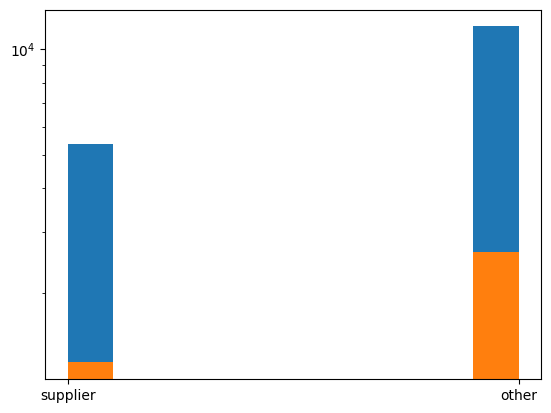

In [13]:
""" Split data set into train&valid splits 
"""


# supplier_concepts= ['manufacturer', 'provider' ,'supplies', 'Supplier', 'supplier', 'provides', 'provide']

# other_concepts = ['subsidiary', 'creditor','investor',
#                'guarantor','lessor','sells products through','issuer',
#                'lessor, manager, or operator','parent','', ' ','partner',
#                 'intermediary', 'primary contract manufacturer','licensee','nothing','competitor','unknown','licensor']

# customer_concepts = ["Customer", 'customer']

# concepts = {"supplier": supplier_concepts,
#        "customer": customer_concepts,
#        "other": other_concepts}

# def map_relation(relation, concepts):
#     for label, concepts in concepts.items():
#         for concept in concepts:
#             if concept in relation:
#                 return label


config_path = 'params.yaml'

            
"""
This function performs data splitting for relation extraction.

:param config_path: (str) path to the configuration file.
:return: None
"""
# Load configuration file
with open(src_dir / config_path) as conf_file:
    config = dict2dot(yaml.safe_load(conf_file))

# Initialize logger and random seed
logger = get_logger('data_split', log_level=config.base['log_level'])
random.seed(config.base.random_state)

# Load input data
data = pd.read_json(src_dir / config.load_data.output_dir)
# Validate input data
missed_columns = set(['entity_1', 'entity_2', 'sents', 'org_groups', 'relations', config.base.index_col, 'Label']) - set(data.columns)
if len(missed_columns) > 0:
    raise ValueError(f"Required columns missed <{','.join(x for x in missed_columns)}>")


train, valid = split_data(data=data,
               index_col = config.base.index_col,
               stratify_by = config.data_split.stratify_by,
                val_size = config.data_split.val_size,
                random_state = config.base.random_state)

assert (train['idx'].isin(valid['idx'])).sum() == 0 

distributions= {}
for stratify_ele in config.data_split.stratify_by:
    distributions[f"train_{stratify_ele}"] = \
    (train[stratify_ele].value_counts()/len(train)).to_dict()
    distributions[f"valid_{stratify_ele}"] = \
    (valid[stratify_ele].value_counts()/len(valid)).to_dict()
    
dist_md = pd.DataFrame(distributions)
logger.info("Train and valid distributions\n{}".format(dist_md.to_markdown()))
# Log label distribution for train and valid data
plt.hist(train.relations, log=True)
plt.hist(valid.relations, log=True)
plt.draw()

# Concatenate weak labels, if any
task_config = config.data_split
if task_config.get('cleansed_labels'):
    cleansed_labels = []
    for fold_path in task_config.get('cleansed_labels'):
        path = os.path.join("data/folds", fold_path)
        data_path = os.path.join(path, 'output.json')
        issues_path = os.path.join(path, 'issues_report.json')
        if os.path.isfile(data_path) and os.path.isfile(issues_path):
            # Read data and issues report
            cleansed_data = pd.read_json(data_path)
            issues_report = pd.read_json(issues_path)

            # Determine pruning fraction to drop from the data
            pruning_indices = issues_report.head(int(task_config.get("issues_pruning", 1) * len(issues_report)))['example']

            # Prune the issues
            cleansed_data = cleansed_data.drop(pruning_indices)
            cleansed_data.reset_index(drop=True, inplace=True)

            # Log data size after pruning
            logger.info(f"data size after pruning {cleansed_data.shape[0]}")
            cleansed_labels.append(cleansed_data)

        else:
            raise FileNotFoundError(f"File '{data_path}' does not exist")

    # Concatenate cleansed labels
    cleansed_data = pd.concat(cleansed_labels, axis=0).reset_index(drop=True)
    cleansed_data[config.base.index_col] = range(len(train), len(train) + len(cleansed_data))

    # Use only weak labels
    if task_config.get("weak_only"):
        train = cleansed_data
    else:
        train = pd.concat([train, cleansed_data], axis=0).reset_index(drop=True)


# Log data distribution for train data
logger.info(f"Train relations distribution:\n {train.relations.value_counts().to_markdown()}")
logger.info(f"Valid relations distribution:\n {valid.relations.value_counts().to_markdown()}")

logger.info("Entity tagging...")

# Create tagged sentences to be tokenized
train = create_re_data(train,
                       'sents',
                       'entity_2',
                       'entity_1',
                       'relations',
                       inverse_dict,
                      static_position=config.base.entity_static_position,
                      num_positions=config.data_split.num_positions)
valid = create_re_data(valid,
                       'sents',
                       'entity_2',
                       'entity_1',
                       'relations',
                       inverse_dict,
                      static_position=config.base.entity_static_position,
                      num_positions=0)

# Save training and validation data
logger.info(f"Saving training set with length={len(train)}")
train.to_json(src_dir / f"{config.data_split.output_dir}/train.json")
logger.info(f"Saving validation set with length={len(valid)}")
valid.to_json(src_dir / f"{config.data_split.output_dir}/valid.json")
dist_md.to_markdown(src_dir / 'data/train/distributions.md')

# **_Train SC Classifier_**

{'base_model': 'nlpaueb/sec-bert-base',
 'batch_size': 45,
 'cuda': '0',
 'epochs': 4,
 'num_workers': 0,
 'seed': 1,
 'truncate': 512,
 'wandb': False,
 'warmup_smooth': 0.8,
 'weight_decay': 0.001,
 'learning_rate': 5e-05,
 'load_pretrained': False,
 'mutate': True,
 'metric_dir': 'sc_metrics'}

In [14]:
from pathlib import Path
import sys 
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

from src.sc_classifier.config.core import config
from src.sc_classifier.trainer import Trainer


def sc_train():
    trainer = Trainer(
            loss_function=CrossEntropyLoss() , 
            optimizer=AdamW,
            load_data=True
    )
    trainer.train(dict(config.train_args))

root==> /notebooks/inferess-relation-extraction


In [15]:
sc_train()

mutate valid text: 100%|██████████| 1469/1469 [00:00<00:00, 2311.28it/s]


2023-10-07 07:46:01,116 — SCClassifier — INFO — ---------Trainig Started---------
2023-10-07 07:46:01,118 — SCClassifier — INFO — EPOCH -- 1


Train Acc: 86.9884: 100%|██████████| 131/131 [01:29<00:00,  1.47batch/s, loss=0.264]

2023-10-07 07:47:30,477 — SCClassifier — INFO — Train-Macro-F1 = 0.8688


  ---------Validation---------
2023-10-07 07:47:40,251 — SCClassifier — INFO — valid set_Loss = 0.2455 | valid set_Acc = 0.9483 | valid set-Macro-F1 = 0.9475
2023-10-07 07:47:40,264 — SCClassifier — INFO — valid macro_f1 increased from 0.0 to 0.9475365032104781 
2023-10-07 07:47:40,265 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-07 07:47:42,023 — SCClassifier — INFO — EPOCH -- 2


Train Acc: 97.2203: 100%|██████████| 131/131 [01:33<00:00,  1.40batch/s, loss=0.074] 

2023-10-07 07:49:15,759 — SCClassifier — INFO — Train-Macro-F1 = 0.9720


  ---------Validation---------
2023-10-07 07:49:26,265 — SCClassifier — INFO — valid set_Loss = 0.0714 | valid set_Acc = 0.9700 | valid set-Macro-F1 = 0.9698
2023-10-07 07:49:26,277 — SCClassifier — INFO — valid macro_f1 increased from 0.9475365032104781 to 0.96980754857997 
2023-10-07 07:49:26,278 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-07 07:49:28,222 — SCClassifier — INFO — EPOCH -- 3


Train Acc: 99.4372: 100%|██████████| 131/131 [01:35<00:00,  1.37batch/s, loss=0.0204]

2023-10-07 07:51:03,942 — SCClassifier — INFO — Train-Macro-F1 = 0.9943


  ---------Validation---------
2023-10-07 07:51:14,425 — SCClassifier — INFO — valid set_Loss = 0.0337 | valid set_Acc = 0.9687 | valid set-Macro-F1 = 0.9685
 val_macro_f1 did not optimize: 0.96980754857997
2023-10-07 07:51:14,469 — SCClassifier — INFO — EPOCH -- 4


Train Acc: 99.7442: 100%|██████████| 131/131 [01:35<00:00,  1.37batch/s, loss=0.0111] 

2023-10-07 07:52:49,948 — SCClassifier — INFO — Train-Macro-F1 = 0.9974


  ---------Validation---------
2023-10-07 07:53:00,454 — SCClassifier — INFO — valid set_Loss = 0.0607 | valid set_Acc = 0.9707 | valid set-Macro-F1 = 0.9705
2023-10-07 07:53:00,465 — SCClassifier — INFO — valid macro_f1 increased from 0.96980754857997 to 0.9705114409558911 
2023-10-07 07:53:00,466 — SCClassifier — INFO — Saving Checkpoint ....
 Highest Macro-F1 score : 0.9705114409558911


# **_Train Concept Classifier_**

In [5]:
from pathlib import Path
import sys 
import yaml
src_dir = Path.cwd().parent
sys.path.append(str(src_dir))
import pandas as pd
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from src.sc_classifier.config.core import config, PACKAGE_ROOT
from src.sc_classifier.trainer import Trainer
from src.sc_classifier.models import constructor
from src.utils import dict2dot

# Read params file
with open(PACKAGE_ROOT / 'params.yaml') as o:
    params = dict2dot(yaml.safe_load(o))
    
# mutate train args to fit
config.app_config.package_name = params.concept_train.package_name
config.ml_model_config.target = "concept_class_remapped"
config.ml_model_config.classes = params['concept_train']['classes']
config.train_args = params.concept_train
config.train_args.metric_dir = "concept_metrics"
config.train_args.max_stratify = 500
config.train_args.prune_stratify = True
trainer = Trainer(
        loss_function=CrossEntropyLoss() , 
        optimizer=AdamW,
        load_data=True,
        model_name= "concept_model",
        config = config
)
#self = trainer

root==> /notebooks/inferess-relation-extraction


(…)/sec-bert-shape/resolve/main/config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

(…)shape/resolve/main/tokenizer_config.json:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

(…)eb/sec-bert-shape/resolve/main/vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

(…)ape/resolve/main/special_tokens_map.json:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

2023-10-19 07:54:07,615 — SCClassifier — INFO — train columns - Index(['sents', 'orig_sents', 'relations', 'org_groups', 'spans', 'Label',
       'concept_class', 'concept_class_remapped', 'idx', 'r_id',
       'relation_tuples'],
      dtype='object')


mutate valid text: 100%|██████████| 884/884 [00:00<00:00, 2230.67it/s]


In [6]:
trainer.train(dict(config.train_args))

2023-10-19 07:54:16,790 — SCClassifier — INFO — ---------Trainig Started---------
2023-10-19 07:54:16,793 — SCClassifier — INFO — EPOCH -- 1


Train Acc: 7.7633: 100%|██████████| 38/38 [00:36<00:00,  1.04batch/s, loss=1.89]

2023-10-19 07:54:53,217 — SCClassifier — INFO — Train-Macro-F1 = 0.0678


  ---------Validation---------
2023-10-19 07:54:59,437 — SCClassifier — INFO — valid set_Loss = 1.7221 | valid set_Acc = 0.3213 | valid set-Macro-F1 = 0.1709
2023-10-19 07:54:59,456 — SCClassifier — INFO — valid macro_f1 increased from 0.0 to 0.17089365022838046 
2023-10-19 07:54:59,457 — SCClassifier — INFO — Saving Checkpoint ....


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



2023-10-19 07:55:01,612 — SCClassifier — INFO — EPOCH -- 2


Train Acc: 28.8712: 100%|██████████| 38/38 [00:35<00:00,  1.06batch/s, loss=1.72]

2023-10-19 07:55:37,367 — SCClassifier — INFO — Train-Macro-F1 = 0.1976


  ---------Validation---------
2023-10-19 07:55:43,576 — SCClassifier — INFO — valid set_Loss = 1.5723 | valid set_Acc = 0.5271 | valid set-Macro-F1 = 0.3101
2023-10-19 07:55:43,600 — SCClassifier — INFO — valid macro_f1 increased from 0.17089365022838046 to 0.3100631001766643 
2023-10-19 07:55:43,602 — SCClassifier — INFO — Saving Checkpoint ....


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



2023-10-19 07:55:46,067 — SCClassifier — INFO — EPOCH -- 3


Train Acc: 44.9853: 100%|██████████| 38/38 [00:36<00:00,  1.05batch/s, loss=1.56]

2023-10-19 07:56:22,177 — SCClassifier — INFO — Train-Macro-F1 = 0.3402


  ---------Validation---------
2023-10-19 07:56:28,323 — SCClassifier — INFO — valid set_Loss = 1.3530 | valid set_Acc = 0.6131 | valid set-Macro-F1 = 0.3994
2023-10-19 07:56:28,345 — SCClassifier — INFO — valid macro_f1 increased from 0.3100631001766643 to 0.3993621605735715 
2023-10-19 07:56:28,347 — SCClassifier — INFO — Saving Checkpoint ....


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



2023-10-19 07:56:30,584 — SCClassifier — INFO — EPOCH -- 4


Train Acc: 56.6513: 100%|██████████| 38/38 [00:35<00:00,  1.06batch/s, loss=1.28]

2023-10-19 07:57:06,563 — SCClassifier — INFO — Train-Macro-F1 = 0.4556


  ---------Validation---------
2023-10-19 07:57:12,760 — SCClassifier — INFO — valid set_Loss = 1.0748 | valid set_Acc = 0.6629 | valid set-Macro-F1 = 0.4901
2023-10-19 07:57:12,783 — SCClassifier — INFO — valid macro_f1 increased from 0.3993621605735715 to 0.49008528293189607 
2023-10-19 07:57:12,784 — SCClassifier — INFO — Saving Checkpoint ....


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



2023-10-19 07:57:15,026 — SCClassifier — INFO — EPOCH -- 5


Train Acc: 66.5967: 100%|██████████| 38/38 [00:35<00:00,  1.06batch/s, loss=1.01]

2023-10-19 07:57:51,026 — SCClassifier — INFO — Train-Macro-F1 = 0.5610


  ---------Validation---------
2023-10-19 07:57:57,188 — SCClassifier — INFO — valid set_Loss = 0.9319 | valid set_Acc = 0.7149 | valid set-Macro-F1 = 0.5949
2023-10-19 07:57:57,207 — SCClassifier — INFO — valid macro_f1 increased from 0.49008528293189607 to 0.5948685794244768 
2023-10-19 07:57:57,209 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-19 07:57:59,204 — SCClassifier — INFO — EPOCH -- 6


Train Acc: 73.5208: 100%|██████████| 38/38 [00:36<00:00,  1.06batch/s, loss=0.776]

2023-10-19 07:58:35,224 — SCClassifier — INFO — Train-Macro-F1 = 0.7092


  ---------Validation---------
2023-10-19 07:58:41,422 — SCClassifier — INFO — valid set_Loss = 0.8073 | valid set_Acc = 0.7477 | valid set-Macro-F1 = 0.7018
2023-10-19 07:58:41,442 — SCClassifier — INFO — valid macro_f1 increased from 0.5948685794244768 to 0.7017659865435698 
2023-10-19 07:58:41,443 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-19 07:58:43,579 — SCClassifier — INFO — EPOCH -- 7


Train Acc: 78.7663: 100%|██████████| 38/38 [00:36<00:00,  1.05batch/s, loss=0.643]

2023-10-19 07:59:19,676 — SCClassifier — INFO — Train-Macro-F1 = 0.7851


  ---------Validation---------
2023-10-19 07:59:25,834 — SCClassifier — INFO — valid set_Loss = 0.8783 | valid set_Acc = 0.7432 | valid set-Macro-F1 = 0.7114
2023-10-19 07:59:25,849 — SCClassifier — INFO — valid macro_f1 increased from 0.7017659865435698 to 0.7113931664963088 
2023-10-19 07:59:25,850 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-19 07:59:27,810 — SCClassifier — INFO — EPOCH -- 8


Train Acc: 82.9207: 100%|██████████| 38/38 [00:35<00:00,  1.06batch/s, loss=0.519]

2023-10-19 08:00:03,536 — SCClassifier — INFO — Train-Macro-F1 = 0.8290


  ---------Validation---------
2023-10-19 08:00:09,665 — SCClassifier — INFO — valid set_Loss = 0.8849 | valid set_Acc = 0.7364 | valid set-Macro-F1 = 0.7112
 val_macro_f1 did not optimize: 0.7113931664963088
2023-10-19 08:00:09,695 — SCClassifier — INFO — EPOCH -- 9


Train Acc: 86.2358: 100%|██████████| 38/38 [00:35<00:00,  1.07batch/s, loss=0.424]

2023-10-19 08:00:45,194 — SCClassifier — INFO — Train-Macro-F1 = 0.8668


  ---------Validation---------
2023-10-19 08:00:51,339 — SCClassifier — INFO — valid set_Loss = 0.9682 | valid set_Acc = 0.7376 | valid set-Macro-F1 = 0.7182
2023-10-19 08:00:51,352 — SCClassifier — INFO — valid macro_f1 increased from 0.7113931664963088 to 0.718191071759997 
2023-10-19 08:00:51,353 — SCClassifier — INFO — Saving Checkpoint ....
2023-10-19 08:00:53,158 — SCClassifier — INFO — EPOCH -- 10


Train Acc: 90.9778: 100%|██████████| 38/38 [00:35<00:00,  1.07batch/s, loss=0.327]

2023-10-19 08:01:28,809 — SCClassifier — INFO — Train-Macro-F1 = 0.9101


  ---------Validation---------
2023-10-19 08:01:34,980 — SCClassifier — INFO — valid set_Loss = 0.9057 | valid set_Acc = 0.7590 | valid set-Macro-F1 = 0.7364
2023-10-19 08:01:34,993 — SCClassifier — INFO — valid macro_f1 increased from 0.718191071759997 to 0.7364268739235564 
2023-10-19 08:01:34,994 — SCClassifier — INFO — Saving Checkpoint ....
 Highest Macro-F1 score : 0.7364268739235564


{'base_model': 'nlpaueb/sec-bert-shape',
 'batch_size': 64,
 'classes': ['revenue',
  'supply_chain',
  'agreement',
  'licensing_and_ip',
  'financial_statements',
  'real_estate'],
 'clip': False,
 'cuda': '0',
 'dev_test_split': False,
 'epochs': 10,
 'features': ['orig_sents'],
 'learning_rate': 1e-05,
 'load_pretrained': False,
 'mutate': True,
 'num_workers': 0,
 'package_name': 'ConceptClassifier',
 'pipeline_name': 'concept_classifier',
 'seed': 1,
 'target': 'concept_class_remapped',
 'train_file': 'data/train/train.json',
 'truncate': 512,
 'valid_file': 'data/train/valid.json',
 'wandb': False,
 'warmup_smooth': 3,
 'weight_decay': 0.001,
 'metric_dir': 'concept_metrics',
 'max_stratify': 500,
 'prune_stratify': True,
 'score': 0.7364268739235564}

In [7]:
trainer.eval(self.train_ds)

2023-10-19 08:02:09,537 — SCClassifier — INFO — valid_Loss = 0.2219 | valid_Acc = 0.9446 | valid-Macro-F1 = 0.9408
2023-10-19 08:02:09,552 — SCClassifier — INFO — ---evaluation---
2023-10-19 08:02:09,559 — SCClassifier — INFO — 
                      precision    recall  f1-score      support
revenue                0.961847  0.958000  0.959920   500.000000
supply_chain           0.931774  0.973523  0.952191   491.000000
agreement              0.919132  0.932000  0.925521   500.000000
licensing_and_ip       0.970522  0.961798  0.966140   445.000000
financial_statements   0.956140  0.881402  0.917251   371.000000
real_estate            0.890244  0.960526  0.924051    76.000000
accuracy               0.944608  0.944608  0.944608     0.944608
macro avg              0.938277  0.944542  0.940846  2383.000000
weighted avg           0.945136  0.944608  0.944485  2383.000000


,precision,recall,f1-score,support
revenue,0.961847,0.958000,0.959920,500.000000
supply_chain,0.931774,0.973523,0.952191,491.000000
agreement,0.919132,0.932000,0.925521,500.000000
licensing_and_ip,0.970522,0.961798,0.966140,445.000000
financial_statements,0.956140,0.881402,0.917251,371.000000
real_estate,0.890244,0.960526,0.924051,76.000000
accuracy,0.944608,0.944608,0.944608,0.944608
macro avg,0.938277,0.944542,0.940846,2383.000000
weighted avg,0.945136,0.944608,0.944485,2383.000000


In [8]:
trainer.eval(self.valid_ds)

2023-10-19 08:02:16,186 — SCClassifier — INFO — valid_Loss = 0.9057 | valid_Acc = 0.7590 | valid-Macro-F1 = 0.7364
2023-10-19 08:02:16,203 — SCClassifier — INFO — ---evaluation---
2023-10-19 08:02:16,209 — SCClassifier — INFO — 
                      precision    recall  f1-score    support
revenue                0.927492  0.777215  0.845730  395.00000
supply_chain           0.601227  0.796748  0.685315  123.00000
agreement              0.642384  0.687943  0.664384  141.00000
licensing_and_ip       0.719697  0.848214  0.778689  112.00000
financial_statements   0.674419  0.617021  0.644444   94.00000
real_estate            0.761905  0.842105  0.800000   19.00000
accuracy               0.759050  0.759050  0.759050    0.75905
macro avg              0.721187  0.761541  0.736427  884.00000
weighted avg           0.779824  0.759050  0.763604  884.00000


,precision,recall,f1-score,support
revenue,0.927492,0.777215,0.845730,395.00000
supply_chain,0.601227,0.796748,0.685315,123.00000
agreement,0.642384,0.687943,0.664384,141.00000
licensing_and_ip,0.719697,0.848214,0.778689,112.00000
financial_statements,0.674419,0.617021,0.644444,94.00000
real_estate,0.761905,0.842105,0.800000,19.00000
accuracy,0.759050,0.759050,0.759050,0.75905
macro avg,0.721187,0.761541,0.736427,884.00000
weighted avg,0.779824,0.759050,0.763604,884.00000


In [9]:
text = trainer.valid_ds['text']
true_labels = trainer.valid_ds['label_id']

In [10]:
output = trainer.predict(text)

100%|██████████| 14/14 [00:21<00:00,  1.54s/batch]


In [11]:
scores, labels = trainer.predict(text)

100%|██████████| 14/14 [00:21<00:00,  1.53s/batch]


In [12]:
classes_scores  =  list(map(lambda x: {trainer.model.config.id2label[k]:v for k,v in enumerate(x)} , scores))
soreted_scores = list(map(lambda x: sorted(x.items(), key=lambda x: x[1], reverse=True) , classes_scores))

#soreted_scores[0][0][0], soreted_scores[0][1][0]

top_2 = list(map(lambda x: [x[0][0], x[1][0]] , soreted_scores ))

In [13]:
prediction_frame = pd.DataFrame({"text":text,
              "expected":list(map(lambda x: trainer.model.config.id2label[x], true_labels) ),
              "predicted":list(map(lambda x: trainer.model.config.id2label[x], labels)),
              "top_2": top_2,
              "score":list(scores.max(1)),
              "scores_dist": soreted_scores,
              "Label":trainer.valid_ds["Label"].tolist()})

In [14]:
prediction_frame.apply(lambda x : x["expected"] in x["top_2"], axis=1).sum() / len(prediction_frame)

0.9117647058823529

In [15]:
# score when the expected concept exists within the top 2 concepts
prediction_frame.apply(lambda x : x["expected"] in x["top_2"], axis=1).sum() / len(prediction_frame)
#output: 0.8039

0.9117647058823529

In [16]:
# score when the expected concept equals the predicted ones
prediction_frame.apply(lambda x : x["expected"] == x['predicted'] , axis=1).sum() / len(prediction_frame)

0.7567873303167421

In [27]:
prediction_frame.apply(lambda x : x["expected"] in x["top_2"] and x['score'] > 0.5, axis=1).sum() / len(prediction_frame)

0.768993839835729

In [125]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)


In [17]:
prediction_frame[prediction_frame.apply(lambda x :x["expected"] != x['predicted'], axis=1)].head(100) 

In [12]:
# Read train and validation sets from JSON files
train = pd.read_json(self.train_file)
valid = pd.read_json(self.valid_file)

# Drop duplicate rows based on an index column
train.drop_duplicates(self.index_col, inplace=True, ignore_index=True)
valid.drop_duplicates(self.index_col, inplace=True, ignore_index=True)
# validate that data contains all required inputs for train and validation
if not all([x in train.columns or x in valid.columns for x in self.basic_columns]):
    raise ("Invalid train or valid dataset, missing required columns...")
# transform inputs using pre-trained transformer tokenizer
if isinstance(valid[self.target].iloc[0], str):

    train[self.target] = train[self.target].apply(lambda x: \
                                            int(self.model.config.label2id[x])) 
    valid[self.target] = valid[self.target].apply(lambda x: \
                                            int(self.model.config.label2id[x]))

In [13]:
train['org_groups']

0       {'AG Mortgage Investment Trust, Inc.': 0, 'REI...
1       {'Bristol Investment Fund Ltd.': 0, 'Wizard Wo...
2       {'Kinder Morgan Inc': 0, 'Kinder Morgan': 0, '...
3                {'US Well Services LLC': 0, 'Antero': 1}
4                  {'Cardinal Health': 0, 'VIVUS Inc': 1}
                              ...                        
6212    {'the PRC Ministry of Commerce': 0, 'CHINA BAK...
6213    {'Paratek Pharmaceuticals Inc': 0, 'Allergan P...
6214    {'Spirit AeroSystems Holdings Inc': 0, 'Boeing...
6215    {'CONE Midstream Partners L.P.': 0, 'CONE Mids...
6216    {'DJO Holdings': 0, 'Guarantors': 1, 'Guaranto...
Name: org_groups, Length: 6217, dtype: object

# train preprocess

In [1]:
""" Split data set into train&valid splits 
"""
import argparse
import joblib
import pandas as pd
from matplotlib import pyplot  as plt
from typing import Text
import yaml
from colorama import Fore
from tqdm import tqdm
from pathlib import Path
import sys 


from src.utils import get_logger, dict2dot
from src.relation_extraction.preprocessing_funcs import preprocess_custom_data


config_path = 'params.yaml'

"""This method tag text to be formated with respect to relation extraction enocder 
"""
with open(src_dir/ config_path) as conf_file:
    config = dict2dot(yaml.safe_load(conf_file))

logger = get_logger('train preprocessing', log_level=config['base']['log_level'])

config.train_preprocess.files = [config.train_preprocess.output_dir+'train.json' ,
                   config.train_preprocess.output_dir+'valid.json']

# train, valid, rm = preprocess_custom_data(config.train_preprocess)
# logger.info(Fore.MAGENTA+f"\ntrain shape: {train.shape}\u2705\nvalid shape: {valid.shape}\u2705\nrelations: {rm.rel2idx}\u2705"+Fore.RESET)



# **_Evaluation_**

2023-10-03 08:16:20,384 — 🌌 spaCy — INFO — Language model used is None
Torch GPU Exists..
2023-10-03 08:16:25,516 — Evaluate — INFO — Loading the pretrained model
2023-10-03 08:16:25,517 — 💫 Relations Extractor — INFO — Loading tokenizer and model...


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 30005. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
10/03/2023 08:16:27 AM [INFO]: Loaded model.


2023-10-03 08:16:27,665 — 💫 Relations Extractor — INFO — Done!


Tagging poles of relations:   0%|          | 0/701 [00:00<?, ?it/s]

mutate text: 100%|██████████| 1200/1200 [00:00<00:00, 5598.63it/s]
10/03/2023 08:16:28 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 1200/1200 [00:00<00:00, 79977.83it/s]



Invalid rows/total: 0/1200


mutate text: 100%|██████████| 1200/1200 [00:00<00:00, 5796.97it/s]
10/03/2023 08:16:32 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 1200/1200 [00:00<00:00, 78794.63it/s]



Invalid rows/total: 0/1200


100%|██████████| 24/24 [00:03<00:00,  6.65it/s]


The classification report:
              precision    recall  f1-score     support
customer       0.690141  0.803279  0.742424   61.000000
other          0.840000  0.923077  0.879581  364.000000
supplier       0.900901  0.746269  0.816327  268.000000
accuracy       0.844156  0.844156  0.844156    0.844156
macro avg      0.810347  0.824208  0.812777  693.000000
weighted avg   0.850361  0.844156  0.843046  693.000000

At threshold `0.9` dropped: datapoint=112
        frac=0.16161616161616166
Classification report for score above threshold:
              precision    recall  f1-score     support
customer       0.854167  0.953488  0.901099   43.000000
other          0.899135  0.948328  0.923077  329.000000
supplier       0.930108  0.827751  0.875949  209.000000
accuracy       0.905336  0.905336  0.905336    0.905336
macro avg      0.894470  0.909856  0.900042  581.000000
weighted avg   0.906949  0.905336  0.904497  581.000000


At threshold `0.95` dropped: datapoint=135
        frac=0.1948

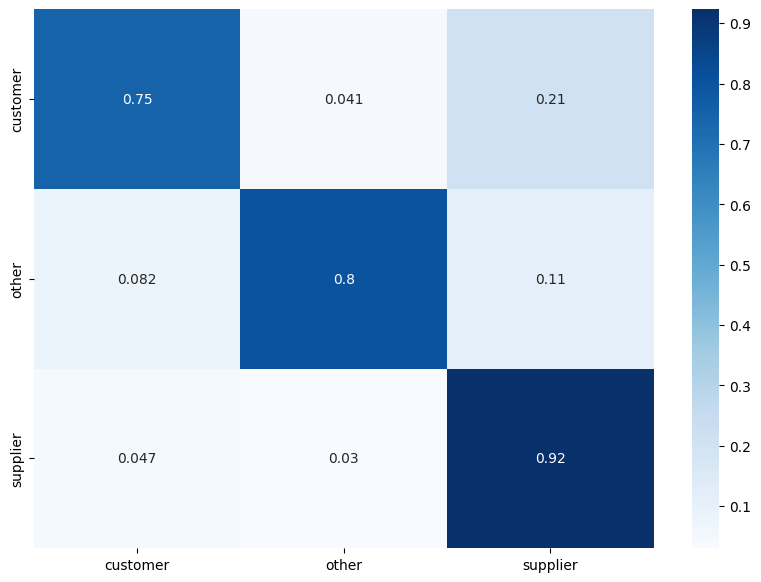

saving test report


mutate text: 100%|██████████| 1200/1200 [00:00<00:00, 4236.28it/s]
10/03/2023 08:16:36 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 1200/1200 [00:00<00:00, 54759.50it/s]



Invalid rows/total: 0/1200


mutate text: 100%|██████████| 1200/1200 [00:00<00:00, 5624.23it/s]
10/03/2023 08:16:41 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 1200/1200 [00:00<00:00, 71599.59it/s]



Invalid rows/total: 0/1200


100%|██████████| 24/24 [00:03<00:00,  6.57it/s]


The classification report:
              precision    recall  f1-score     support
customer       0.906667  0.761194  0.827586  268.000000
other          0.840399  0.925824  0.881046  364.000000
supplier       0.731343  0.803279  0.765625   61.000000
accuracy       0.851371  0.851371  0.851371    0.851371
macro avg      0.826136  0.830099  0.824752  693.000000
weighted avg   0.856427  0.851371  0.850212  693.000000

At threshold `0.9` dropped: datapoint=110
        frac=0.15873015873015872
Classification report for score above threshold:
              precision    recall  f1-score     support
customer       0.931217  0.826291  0.875622  213.000000
other          0.899135  0.954128  0.925816  327.000000
supplier       0.872340  0.953488  0.911111   43.000000
accuracy       0.907376  0.907376  0.907376    0.907376
macro avg      0.900898  0.911303  0.904183  583.000000
weighted avg   0.908880  0.907376  0.906393  583.000000


At threshold `0.95` dropped: datapoint=137
        frac=0.1976

<Figure size 640x480 with 0 Axes>

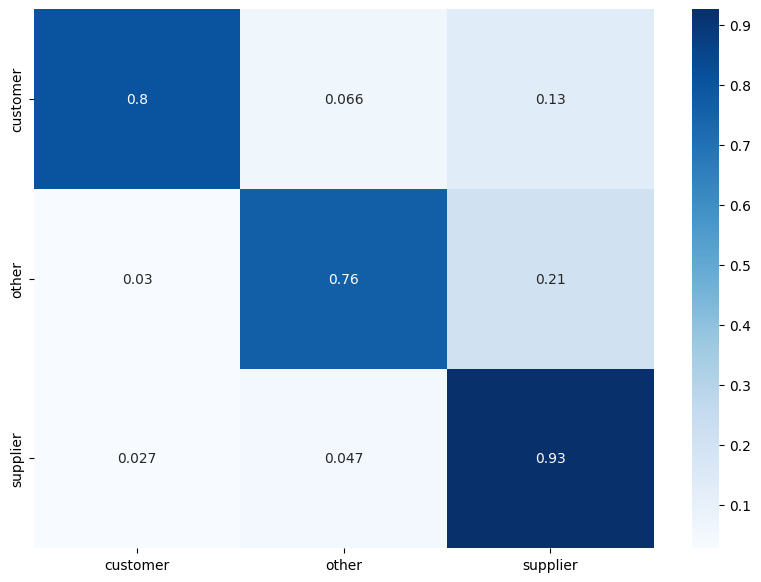

mutate text: 100%|██████████| 5922/5922 [00:00<00:00, 6220.54it/s]
10/03/2023 08:16:46 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 5922/5922 [00:00<00:00, 79301.54it/s]



Invalid rows/total: 0/5922


mutate text: 100%|██████████| 5922/5922 [00:01<00:00, 5847.59it/s]
10/03/2023 08:17:10 AM [INFO]: Tokenizing data...
tags positioning: 100%|██████████| 5922/5922 [00:00<00:00, 44245.89it/s]



Invalid rows/total: 0/5922


100%|██████████| 119/119 [00:23<00:00,  5.16it/s]


The classification report:
              precision    recall  f1-score      support
customer       0.936327  0.925166  0.930713  1510.000000
other          0.967842  0.964507  0.966172  2902.000000
supplier       0.908322  0.925166  0.916667  1510.000000
accuracy       0.944444  0.944444  0.944444     0.944444
macro avg      0.937497  0.938279  0.937850  5922.000000
weighted avg   0.944630  0.944444  0.944508  5922.000000

At threshold `0.9` dropped: datapoint=340
        frac=0.05741303613644044
Classification report for score above threshold:
              precision    recall  f1-score      support
customer       0.961398  0.954447  0.957910  1383.000000
other          0.982525  0.978338  0.980427  2816.000000
supplier       0.940214  0.955170  0.947633  1383.000000
accuracy       0.966679  0.966679  0.966679     0.966679
macro avg      0.961379  0.962652  0.961990  5582.000000
weighted avg   0.966808  0.966679  0.966723  5582.000000


At threshold `0.95` dropped: datapoint=478
     

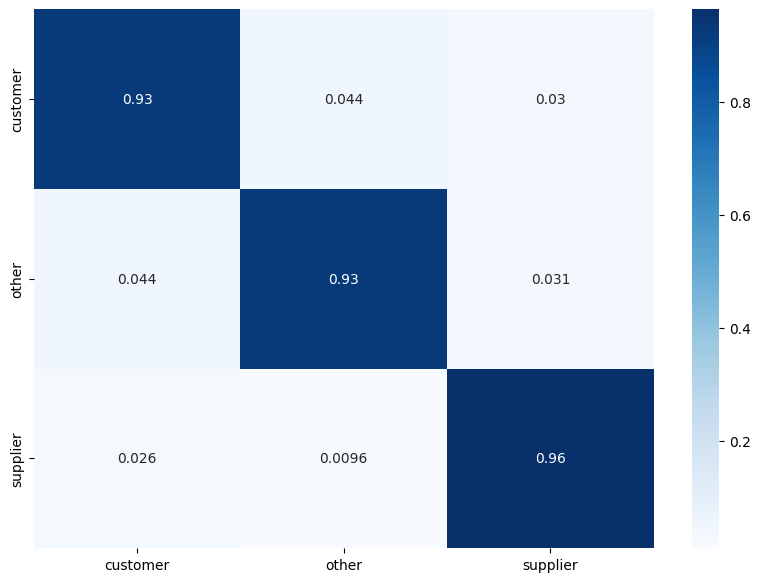

saving dev report


<Figure size 640x480 with 0 Axes>

In [2]:
import argparse
import json
import pandas as pd
import numpy as np
from typing import Text
import yaml
from colorama import Fore
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
src_dir = Path.cwd().parent
sys.path.append(str(src_dir)) 
from src.utils.logs import get_logger
from src.utils.data import dict2dot
from sklearn.metrics import classification_report, confusion_matrix
from src.relation_extraction.infer import infer_from_trained
from src.relation_extraction.preprocessing_funcs import (inverse_relations,
                                                        inverse_dict)
from src.utils.preprocess import create_re_data, get_source, entity_annotation
from src.relation_extraction.misc import create_org_groups #,evaluation_report
from src.language_model.spacy_loader import SpacyLoader

config_path = 'params.yaml'

"""
Load and validate data
""" 

"""Load raw data.
Args:
    config_path {Text}: path to config
"""

with open(src_dir/ config_path) as conf_file:
    config = dict2dot(yaml.safe_load(conf_file))

logger = get_logger('Evaluate', log_level=config.base['log_level'])
## Modify params with what fits evaluation 
config['train']['inverse']= False 
config['train']['replace_ent']= False 
## Read relations file
test_data = pd.read_json(src_dir / config.evaluate['dataset'])
test_data = test_data.dropna(subset=[config.evaluate.text_col])
## Check missed columns 
missed_columns = set([config.evaluate.text_col,
  config.evaluate.entity_1,
  config.evaluate.entity_2,
  config.evaluate.target]) - set(test_data.columns)

# define the dataset metadata used for the training
dataset_name = Path(config.load_data.dataset).name.split('.')[0]
# read yaml config associated to the dataset
with open(src_dir /'data/config/{}.yaml'.format(dataset_name), 'r')as o:
    data_files = yaml.safe_load(o)
    data_sources = {x:Path(y['dir']).name for x,y in data_files.items()}
# load the ids mapping dict
ids_map = np.load(src_dir / "data/train/row_ids.npy", allow_pickle=True)


if len(missed_columns) > 0: 
    raise ValueError(f"Required columns missed <{','.join(x for x in missed_columns)}>")
# Save sentence id for later use
if config.base.index_col not in test_data.columns: 
    test_data[config.base.index_col] = list(range(len(test_data)))
## If spans pre-detected don't load entity extractor        
test_data = test_data.drop_duplicates(subset = [config.evaluate.text_col,
                           config.evaluate.entity_1, 
                           config.evaluate.entity_2,]).reset_index(drop=True)
## Clean the test_data using preprocess pipe
test_data.rename(columns={config.evaluate.text_col:'orig_sent',
                 config.evaluate.entity_1:'entity_1',
                 config.evaluate.entity_2: 'entity_2', 
                 config.evaluate.target: 'relations',
                 config.evaluate.spans: 'spans'}, inplace=True)

test_data["org_groups"] = test_data.spans.apply(lambda x : create_org_groups(x))
# Setup the basic targets
test_data['relations'] = test_data['relations'].apply\
(lambda x : x if x in config.base.main_relations else 'other')
# Check spans
extract_ent = False if 'spans' in test_data.columns else True
if not extract_ent:
    from src.language_model.spacy_loader import Docs_Container, SpacyLoader
    # 
    docs_container = Docs_Container()
    docs_container._docs,\
    docs_container._spans,\
    docs_container._ents = (test_data['orig_sent'].tolist(),
                            test_data['spans'].tolist(),
                            test_data['org_groups'].apply(lambda x : set(x.keys())).to_list())

    spacy_loader = SpacyLoader(lm=None,
                               require_gpu = True,
                               entity_matcher= str(src_dir / "artifacts/matcher_model"),
                               load_matcher=True)
    group_docs, aliases_docs = spacy_loader.group_ents(docs_container)
    test_data.loc[:, 'org_groups']= group_docs

# Initiate the inferer
inferer = infer_from_trained(detect_entities=extract_ent,
                             language_model="en_core_web_trf",
                             require_gpu=True,
                             basic_targets= ['supplier','customer'],
                             load_matcher=True
                            )

if extract_ent: 
    sents, spans, groups, aliases = inferer.spacy_loader.predictor(test_data['orig_sent'].tolist())
    test_data.loc[:, 'sents'] = sents
    test_data.loc[:, 'spans'] = spans
    test_data.loc[:, 'org_groups'] = groups
    test_data.loc[:, 'aliases'] = aliases

# Load fine-tune model
logger.info("Loading the pretrained model")
inferer.load_model({'model_path': str(src_dir / config.train.model_path),
                   'batch_size': config.train.batch_size})
tagged = create_re_data(test_data,
               'orig_sent',
               'entity_2',
               'entity_1',
               'relations',
               inverse_dict,
               static_position=config.base['entity_static_position'],
              ).dropna(axis='columns')
if len(missed_columns) > 0: 
    raise ValueError(f"Required columns missed <{','.join(x for x in missed_columns)}>")

# Inverse the entity_tags
inverse_data = tagged.copy()
inverse_data.sents = inverse_data.sents.apply(inverse_relations)
assert not all(inverse_data.sents == tagged.sents)
inverse_data.relations = inverse_data.relations.apply(
    lambda x: inverse_dict[x]
)

# Test metricsa and errors reporting 
test_errors, test_output = evaluation_report(inferer=inferer,
                  tagged_data=tagged,
                  tag_name='test',
                  report_dir= str(src_dir/ 'metrics'),
                  mutate= config.evaluate['mutate'],
                  reverse= config.evaluate['reverse'],
                  save_reports=True)
# Inverse tags errors
test_inv_errors, test_inv_output = evaluation_report(inferer=inferer,
                  tagged_data=inverse_data,
                  tag_name='test',
                  report_dir= str(src_dir/ 'metrics'),
                  mutate= config.evaluate['mutate'],
                  reverse= config.evaluate['reverse'],
                  save_reports=False)

test_output["inverse_prediction"] = test_inv_output.prediction.apply(lambda x : inverse_dict[x])
test_output['inverse_score'] = test_inv_output['score']
direction_conflict = test_output.query("prediction != inverse_prediction")
direction_conflict.drop(columns=['spans', 'prediction_id'])\
                  .to_excel(src_dir / "metrics/test_inconsistent_directions.xlsx")



# create evaluation report for the dev-set
dev_data = pd.read_json(src_dir / config['train']['valid_data'])

if config.evaluate.return_source:
    dev_data.loc[:, 'source_data'] = dev_data[config.base.index_col]\
    .apply(lambda x : get_source(ids_map,data_sources,x))
# Inverse the entity_tags
dev_inverse = dev_data.copy()
dev_inverse.sents = dev_inverse.sents.apply(inverse_relations)
assert not all(dev_inverse.sents == dev_data.sents)
dev_inverse.relations = dev_inverse.relations.apply(
    lambda x: inverse_dict[x]
)
assert not all(dev_inverse.relations == dev_data.relations)

# Dev metrics and errors reports 
dev_errors, dev_output = evaluation_report(inferer=inferer,
                  tagged_data=dev_data.drop(columns=['r_id']),
                  tag_name='dev',
                  report_dir= str(src_dir/ 'metrics'),
                  mutate= config.evaluate['mutate'],
                  reverse= config.evaluate['reverse'],
                  save_reports=True)
# Inverse tags errors
dev_inv_errors, dev_inv_output = evaluation_report(inferer=inferer,
                  tagged_data=dev_inverse,
                  tag_name='dev',
                  report_dir= str(src_dir/ 'metrics'),
                  mutate= config.evaluate['mutate'],
                   reverse= config.evaluate['reverse'],

                   save_reports=False)
